# Assignment 1

Obtain the 200 top-ranking universities in www.topuniversities.com (ranking 2018). In particular, extract the following fields for each university: name, rank, country and region, number of faculty members (international and total) and number of students (international and total). Some information is not available in the main list and you have to find them in the details page. Store the resulting dataset in a pandas DataFrame. 

By aggregating data in following ways:
* by country
* by region

answer which are the best universities in terms of: 

* ratio between faculty members and students
* ratio of international students

In [2]:
# Imports
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from bs4 import BeautifulSoup as bs
from IPython.core import display as ICD # Used to display multiple dataframes from same cell
import difflib, re, unidecode


In [ ]:
# Constants
TOTAL_STAFF_COUNT = 'total_staff_count'
INTERNATIONAL_STAFF_COUNT = 'international_staff_count'
TOTAL_STUDENT_COUNT = 'total_student_count'
INTERNATIONAL_STUDENT_COUNT = 'international_student_count'

# URLs
# Top Universities
TOP_UNIVERSITIES_BASE_URL = 'https://www.topuniversities.com'
TOP_UNIVERSITIES_RANKNING_URL = 'https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1507982846110'
# Times Higher Education
TIMES_HIGHER_EDUCATION_BASE_URL = 'https://www.timeshighereducation.com'
TIMES_HIGHER_EDUCATION_RANKING_URL = 'https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json'

In [ ]:
def form_region_dictionary(items, country_key, region_key):
    dictionary = {}
    for item in items:
        # If region is present, update it's contents if needed
        if (item[region_key] in dictionary) and (item[country_key] not in dictionary[item[region_key]]):
            dictionary[item[region_key]].append(item[country_key])
        # If region is not present, create it and put first item
        elif item[region_key] not in dictionary:
            dictionary[item[region_key]] = [item[country_key]]
    return dictionary

def add_region(item, country_key, region_dictionary, default_value='Unknown'):
    result = item.copy()
    result['region'] = default_value
    
    for region, countries in region_dictionary.items():
        if result[country_key] in countries:
            result['region'] = region
            break
    
    return result

def percentage_from_string(word):
    perc = word.strip()
    if perc[-1:] == '%':
        perc = perc[:-1]
    return float(perc) / 100

def int_from_string(word):
    return int("".join(i for i in list(word.strip()) if i.isdigit()))

def float_from_string(word):
    return float("".join(i for i in list(word.strip()) if i.isdigit() or i=='.'))
    
# Helper methods for 'Top Universities'
def tu_parse_ranking(json):
    return list(map(lambda wrapper: { 
            'country' : wrapper['country'],
            'name' : wrapper['title'], 
            'rank' : wrapper['rank_display'], 
            'region' : wrapper['region'],
            'url' : wrapper['url']
        }, json))

def tu_staff_and_students(university):    
    UNI_URL = TOP_UNIVERSITIES_BASE_URL + university['url']
    r = requests.get(UNI_URL)
    
    soup = bs(r.text, 'html.parser')
    result = university.copy()
    
    # Total faculty staff count
    total_staff_wrapper = soup.find('div', class_='total faculty')
    total_staff_count = 0
    
    if total_staff_wrapper:
        total_staff_count = int_from_string(total_staff_wrapper.find('div', class_='number').text)
    
    result[TOTAL_STAFF_COUNT] = total_staff_count
    
    # International faculty staff count
    international_staff_wrapper = soup.find('div', class_='inter faculty')
    international_staff_count = 0
    
    if international_staff_wrapper:
        international_staff_count = int_from_string(international_staff_wrapper.find('div', class_='number').text)

    result[INTERNATIONAL_STAFF_COUNT] = international_staff_count
    
    # Total students count
    total_student_wrapper = soup.find('div', class_='total student')
    total_student_count = 0
    
    if total_student_wrapper:
        total_student_count = int_from_string(total_student_wrapper.find('div', class_='number').text)
    
    result[TOTAL_STUDENT_COUNT] = total_student_count
    
    # International students count
    international_student_wrapper = soup.find('div', class_='total inter')
    international_student_count = 0
    
    if international_student_wrapper:
        international_student_count = int_from_string(international_student_wrapper.find('div', class_='number').text)
    
    result[INTERNATIONAL_STUDENT_COUNT] = international_student_count
    
    return result

# Helper methods for 'Times Higher Education'
def the_parse_ranking(json):
    return list(map(lambda wrapper: {
            'country' : wrapper['location'],
            'name' : wrapper['name'],
            'rank' : wrapper['rank'],
            'url' : wrapper['url']
        }, json))

def the_staff_and_students(university):
    UNI_URL = TIMES_HIGHER_EDUCATION_BASE_URL + university['url']
    r = requests.get(UNI_URL)

    soup = bs(r.text, 'html.parser')
    result = university.copy()

    pane = soup.find('div', class_='panel-pane pane-data-stats')
    elements = pane.find_all('li')
    
    international_student_perc = None
    staff_to_student_ratio = None
    total_student_count = None
    
    for element in elements:
        # International student percentage        
        if element.find('div', class_='keystats pc_intl_students') != None:
            international_student_perc_text = element.find('div', class_='value').text
            international_student_perc = percentage_from_string(international_student_perc_text)
        # Total faculty staff ratio
        elif element.find('div', class_='keystats student_staff_ratio') != None:
            staff_to_student_ratio_text = element.find('div', class_='value').text
            staff_to_student_ratio = float_from_string(staff_to_student_ratio_text)
        # Total student count
        elif element.find('div', class_='keystats number_students') != None:
            total_student_count_text = element.find('div', class_='value').text
            total_student_count = int_from_string(total_student_count_text)
    
    result[TOTAL_STAFF_COUNT] = int(total_student_count / staff_to_student_ratio)
    
    # There is no data avilable on international staff count
    result[INTERNATIONAL_STAFF_COUNT] = 0
    
    result[TOTAL_STUDENT_COUNT] = total_student_count
    result[INTERNATIONAL_STUDENT_COUNT] = int(total_student_count * international_student_perc)
        
    return result

#### Retrieving data from 'TopUniversities' ranking site



In [ ]:
r = requests.get(TOP_UNIVERSITIES_RANKNING_URL)
response_json = r.json()['data']

universities = tu_parse_ranking(response_json)
universities = list(map(tu_staff_and_students, universities))

# Forming 'Top Universities' data frame
tu_df = pd.DataFrame.from_dict(universities)

#### Forming region dictionary

In the next part of the exercise we will retrieve data from 'Times Higher Education' university ranking website which does not have region information coupled with inofrmation about the universities. We can solve this problem by forming 'region dictionary' whose keys will be regions introduced in 'Top Universities' data frame, and whose values will be countries associated with said regions and which were also introduced in 'Top Universities' data frame.

In [ ]:
region_dictionary = form_region_dictionary(response_json, 'country', 'region')

#### Retrieving data from 'Times Higher Education' ranking site



In [ ]:
r = requests.get(TIMES_HIGHER_EDUCATION_RANKING_URL)
response_json = r.json()['data']

universities = the_parse_ranking(response_json)
universities = list(map(lambda u: add_region(u, 'country', region_dictionary), universities))
universities = list(map(the_staff_and_students, universities))

# Forming 'Times Higher Education' data frame
the_df = pd.DataFrame.from_dict(universities)

#### Adjusting ranks in data frames

Dataframes which we obtained from both ranking sites contain ranks which are not unique to every univeristy. Cases exist where serveral universities share the same rank. We will adjust this and make rank unique to each university in each dataframe by utilizing original order in which univerities appeared on ladders.

In [ ]:
tu_df['rank'] = range(1, len(tu_df['rank']) + 1)
the_df['rank'] = range(1, len(the_df['rank']) + 1)

the_df = the_df.head(n=200)
tu_df = tu_df.head(n=200)

# Save the datasets to use them again later
the_df.to_pickle("the_dataset")
tu_df.to_pickle("tu_dataset")


tu_df.head()

In [ ]:
the_df.head()

In [3]:
# Read saved dataset to avoid recrawling both entire sites
the_df = pd.read_pickle("the_dataset")
tu_df = pd.read_pickle("tu_dataset")

## Top Universities data

#### Exploring the data

We will answer the following questions for the www.topuniversities.com dataset:

 - Which are the best universities in terms of:
     1. ratio between faculty members and students
     2. ratio of international students

We also show the same statistics per country and per region

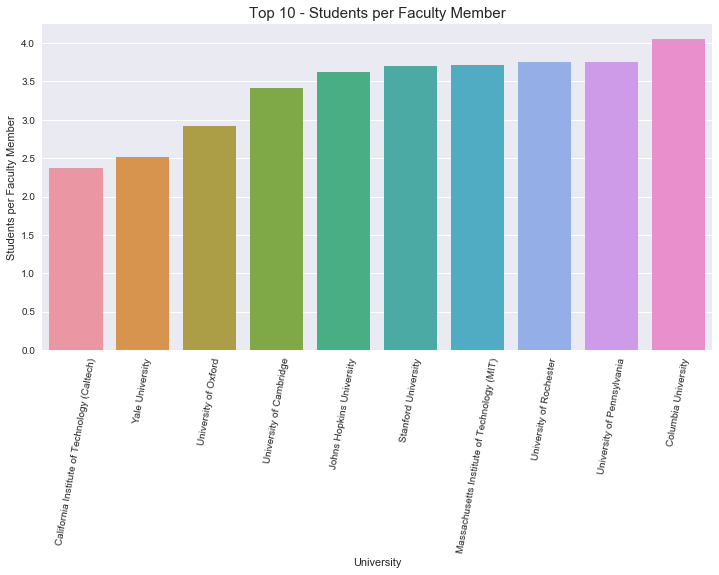

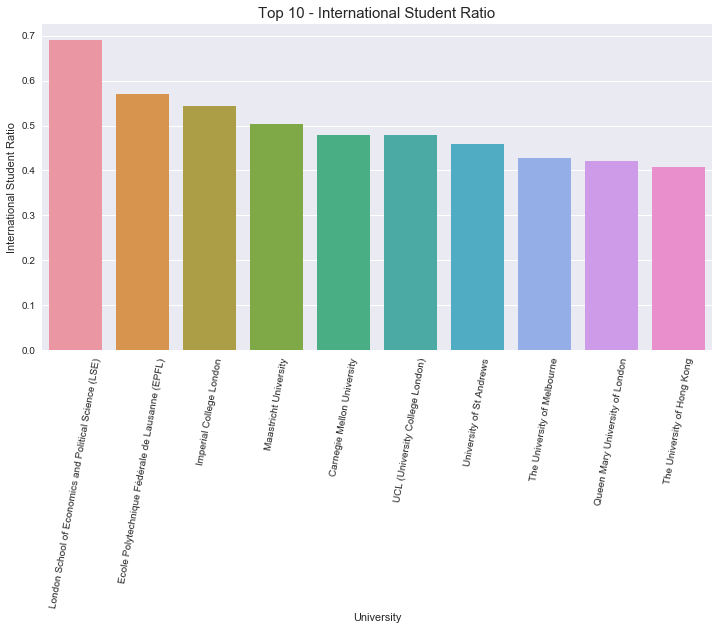

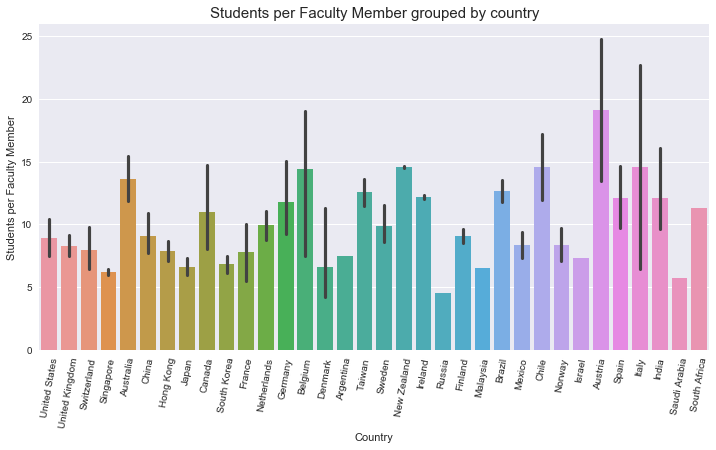

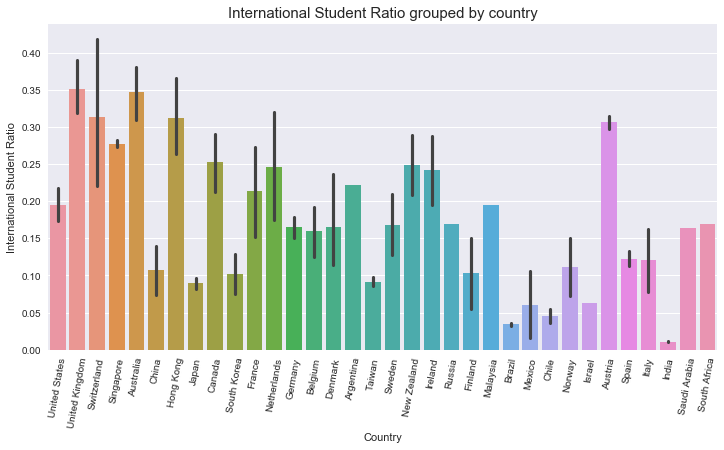

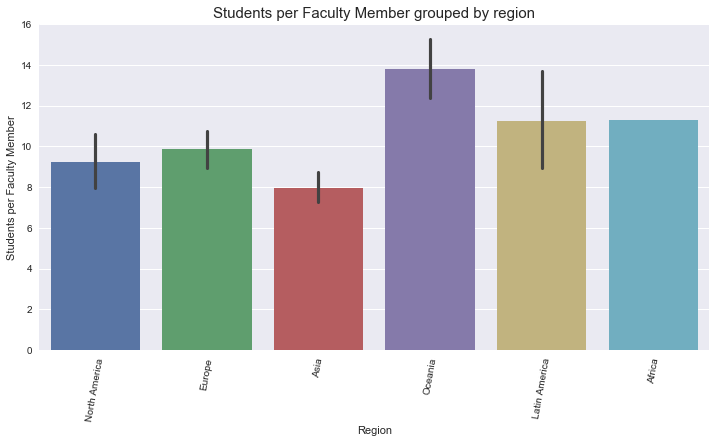

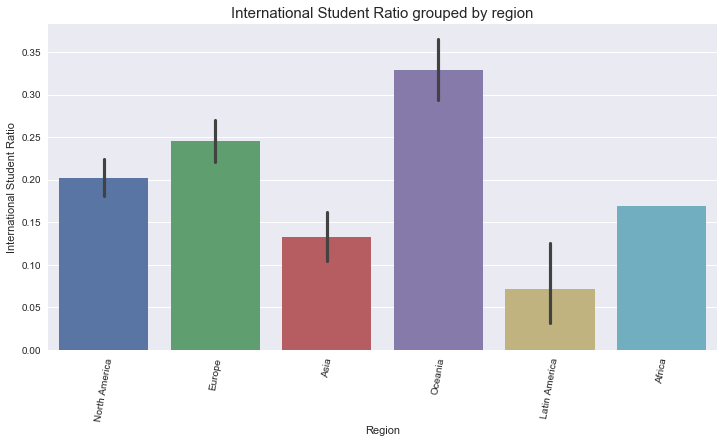

In [131]:
plot_labels = {
    'total_student_count': 'Students per Faculty Member',
    'international_student_count': 'International Student Ratio',
    'country': 'Country',
    'region' : 'Region'
}

def plot_ratio(df, stat, groupby=None, print_table=False):
    # create plot
    fig, ax = plt.subplots()
    
    # calculate ratio
    if stat == 'staff':
        asc = True
        col_name = plot_labels['total_student_count']
        ratio = df['total_student_count'].div(df['total_staff_count'])
    elif stat == 'int':
        asc = False
        col_name = plot_labels['international_student_count']
        ratio = df['international_student_count'].div(df['total_student_count'])

    if groupby is not None:
        title = col_name + " grouped by " + groupby
        
        # create new dataframe
        fsr = pd.concat([df[groupby], ratio], axis=1)
        lbl = plot_labels[groupby]
        fsr.columns = [lbl, col_name]
        fsr_g = fsr.groupby([lbl])[col_name].mean().to_frame()
        fsr_g['std'] = fsr.groupby([lbl])[col_name].std().to_frame()
        #fsr_g.sort_values(by=fsr_g.index, inplace=True, ascending=asc)
        if print_table:
            ICD.display(fsr_g)
        sns.barplot(x=lbl, y=col_name, data=fsr, ax=ax)
    else:
        title = "Top 10 - " + col_name
        
        # create new dataframe
        fsr = pd.concat([df.name, ratio], axis=1)
        fsr.columns = ['University', col_name]
        fsr = fsr.sort_values(by=col_name, ascending=asc)[:10]
        if print_table:
            ICD.display(fsr)
        sns.barplot(fsr['University'], fsr[col_name], ax=ax)

    ax.set_title(title, fontsize=15)
    plt.rcParams['figure.figsize']=(12,6)
    plt.xticks(rotation=80)
    plt.ylabel(col_name)
    return plt

# tu plots
plot_ratio(tu_df, 'staff').show()
plot_ratio(tu_df, 'int', ).show()
plot_ratio(tu_df, 'staff', 'country').show()
plot_ratio(tu_df, 'int', 'country').show()
plot_ratio(tu_df, 'staff', 'region').show()
plot_ratio(tu_df, 'int', 'region').show()

## Times Higher Education data

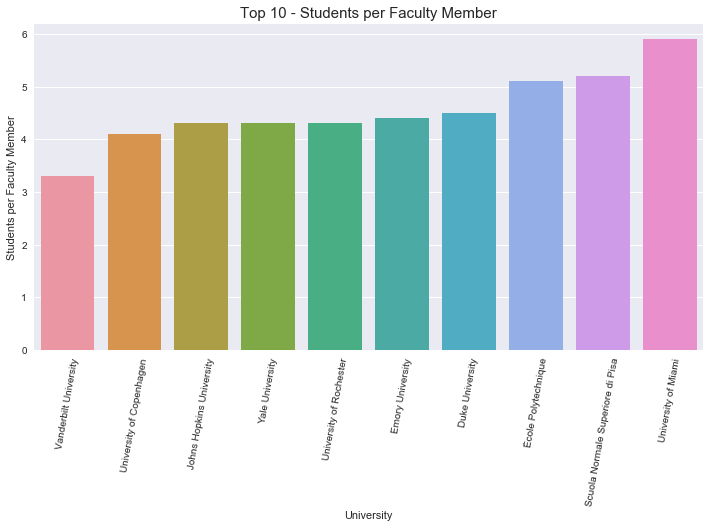

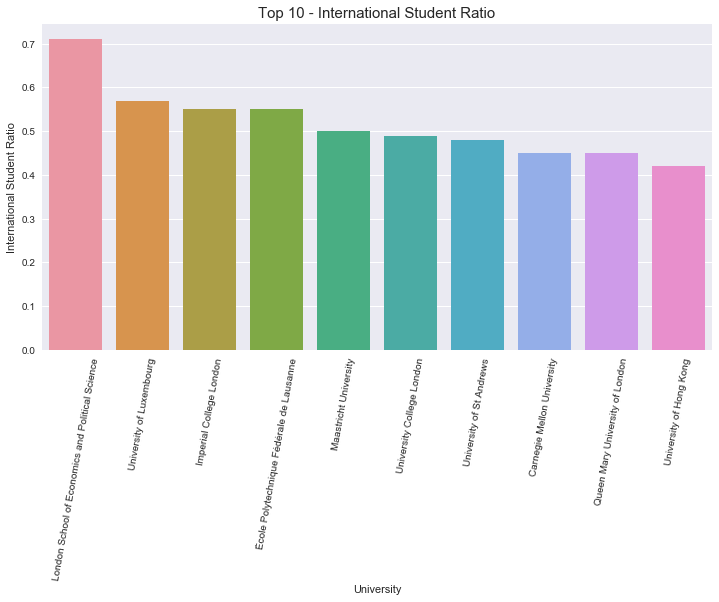

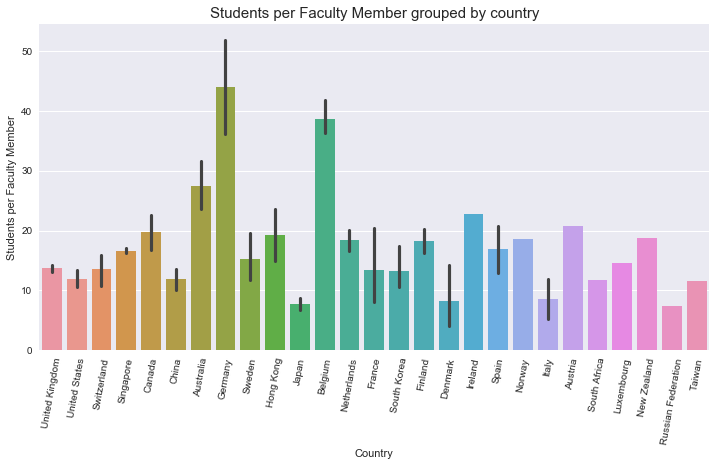

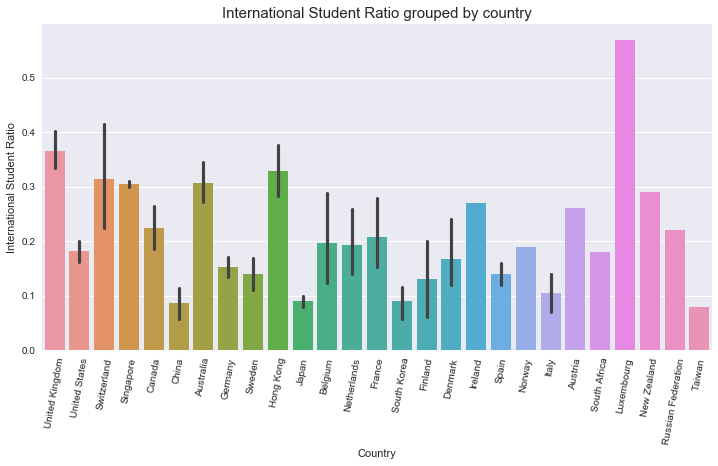

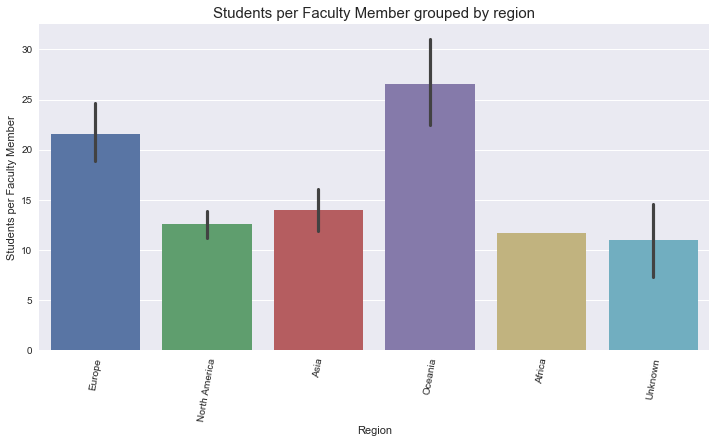

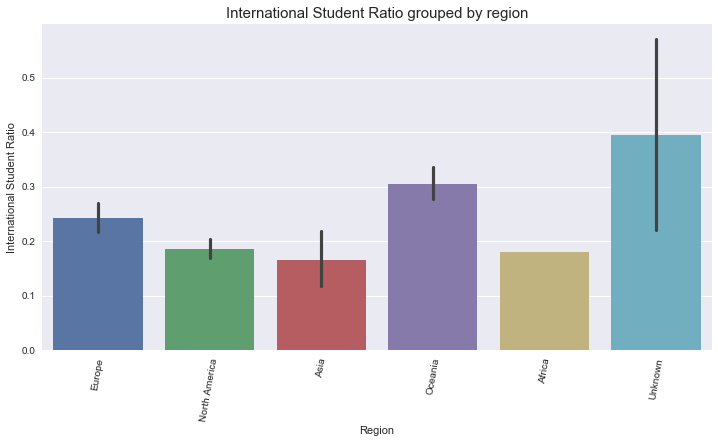

In [132]:
# the plots
plot_ratio(the_df, 'staff').show()
plot_ratio(the_df, 'int', ).show()
plot_ratio(the_df, 'staff', 'country').show()
plot_ratio(the_df, 'int', 'country').show()
plot_ratio(the_df, 'staff', 'region').show()
plot_ratio(the_df, 'int', 'region').show()

#### Matching entries by name
Let us look at the universities that are present in both data sets. Some are present in both rankings, and some are unique to either ranking. We should make sure that each university only occurs once in each dataset to avoid Problems when matching the two sets. 

In [5]:
the_names_unique = len(set(the_df['name'])) == len(list(the_df['name']))
tu_names_unique = len(set(tu_df['name'])) == len(list(tu_df['name']))

print("University names of the_df are uniqe: {}".format(the_names_unique))
print("University names of tu_df are uniqe: {}".format(the_names_unique))

University names of the_df are uniqe: True
University names of tu_df are uniqe: True


The names of the universities are unique. Now let us find out how many are identical in both datasets.

In [6]:
# University names for both rankings
the_names = set(the_df.name)
tu_names = set(tu_df.name)

# University names present in both data sets
in_both = the_names.intersection(tu_names)
print("Number of universities in both rankings: {}".format(len(in_both)))

# University names only present in the_names
only_in_the = the_names.difference(tu_names)
print("Number of universities only in the_names: {}".format(len(only_in_the)))

# University names only present in tu_names
only_in_tu = tu_names.difference(the_names)
print("Number of universities only in tu_names: {}".format(len(only_in_tu)))

Number of universities in both rankings: 105
Number of universities only in the_names: 95
Number of universities only in tu_names: 95


In [14]:
def get_word_frequencies(university_names):
    freqs = {}
    for name in university_names:
        for word in name.split(' '):
            if word in freqs:
                freqs[word] += 1
            else:
                freqs[word] = 1
    return {k: v for k, v in freqs.items() if v > 2}
    
word_freq_dict = get_word_frequencies(only_in_the.union(only_in_tu))
common_words = ['University', 'Science',  'Technology', 'The', 'College', 
                'Institute', '–',  'National', 'Ecole', 'Polytechnique', 
                'and', 'Universidad', '-', 'State', 
                'Université', '&']
#print(sorted(word_freq_dict.items(), key=lambda x:x[1]))
print(word_freq_dict.keys())

def clean_string(string):
    # replace unicode by ascii
    string = unidecode.unidecode(string)
    # remove common words
    for word in common_words:
        string = string.replace(word, '')
    # sort words lexicographically
    string = ' '.join(sorted(string.split(' ')))
    return string

def find_matches(word, words):
    lookup = {}
    word = clean_string(word)
    cleaned = set()
    for entry in words:
        temp = clean_string(entry)
        cleaned.add(temp)
        lookup[temp] = entry
    return lookup, difflib.get_close_matches(word, cleaned, n=1, cutoff=0.7)

def create_matching_dict():
    matching_dict = {}
    count = 0
    for word in list(only_in_the):
        lookup, matches = find_matches(word, only_in_tu)
        if matches:
            count += 1
            matching_dict[word] = lookup[matches[0]]
    print(count)
    return matching_dict

def patch_df(df):
    df_c = df.copy()
    matching_dict = create_matching_dict()
    for i, name in enumerate(df_c.name):
        if name in matching_dict:
            df_c.name[i] = matching_dict[name]
    return df_c

matching_dict = create_matching_dict()
for match in matching_dict:
    print(match + " -> " + matching_dict[match])

dict_keys(['University', 'of', 'de', 'Barcelona', 'Science', 'Technology', 'The', 'Sydney', 'College', 'London', 'California,', 'Indian', 'Institute', 'Zurich', '–', 'National', 'Berlin', 'Tokyo', 'Ecole', 'Polytechnique', 'Western', 'Hong', 'Kong', 'and', 'Dublin', 'New', 'di', 'Universidad', 'Korea', '-', 'Massachusetts', 'State', 'Santa', 'Paris', 'Université', '&', 'Singapore'])
44
University of Auckland -> The University of Auckland
University College London -> King's College London
University of California, San Diego -> University of California, San Diego (UCSD)
ETH Zurich – Swiss Federal Institute of Technology Zurich -> ETH Zurich - Swiss Federal Institute of Technology
National Taiwan University -> National Taiwan University (NTU)
Hong Kong University of Science and Technology -> The Hong Kong University of Science and Technology
Washington University in St Louis -> Washington University in St. Louis
University of Sydney -> University of Technology Sydney
University of Adelaid

In [152]:
merged_df = pd.merge(patch_df(the_df), tu_df, how='inner', on=['name', 'region'], suffixes=('_the', '_tu'))
merged_df

/opt/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,country_the,international_staff_count_the,international_student_count_the,name,rank_the,region,total_staff_count_the,total_student_count_the,url_the,country_tu,international_staff_count_tu,international_student_count_tu,rank_tu,total_staff_count_tu,total_student_count_tu,url_tu
0,United Kingdom,0,7755,University of Oxford,1,Europe,1822,20409,/world-university-rankings/university-oxford,United Kingdom,2964,7353,6,6750,19720,/universities/university-oxford
1,United Kingdom,0,6436,University of Cambridge,2,Europe,1687,18389,/world-university-rankings/university-cambridge,United Kingdom,2278,6699,5,5490,18770,/universities/university-cambridge
2,United States,0,596,California Institute of Technology (Caltech),3,North America,339,2209,/world-university-rankings/california-institut...,United States,350,647,4,953,2255,/universities/california-institute-technology-...
3,United States,0,3485,Stanford University,4,North America,2112,15845,/world-university-rankings/stanford-university,United States,2042,3611,2,4285,15878,/universities/stanford-university
4,United States,0,3800,Massachusetts Institute of Technology (MIT),5,North America,1284,11177,/world-university-rankings/massachusetts-insti...,United States,1679,3717,1,2982,11067,/universities/massachusetts-institute-technolo...
5,United States,0,8292,Massachusetts Institute of Technology (MIT),191,North America,4453,59230,/world-university-rankings/university-massachu...,United States,1679,3717,1,2982,11067,/universities/massachusetts-institute-technolo...
6,United States,0,5284,Harvard University,6,North America,2283,20326,/world-university-rankings/harvard-university,United States,1311,5266,3,4350,22429,/universities/harvard-university
7,United States,0,1909,Princeton University,7,North America,958,7955,/world-university-rankings/princeton-university,United States,246,1793,13,1007,8069,/universities/princeton-university
8,United Kingdom,0,8721,Imperial College London,8,Europe,1390,15857,/world-university-rankings/imperial-college-lo...,United Kingdom,2071,8746,8,3930,16090,/universities/imperial-college-london
9,United States,0,3381,University of Chicago,9,North America,2181,13525,/world-university-rankings/university-chicago,United States,635,3379,9,2449,13557,/universities/university-chicago
